In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.3 MB/s 
     |████████████████████████████████| 7.6 MB 33.8 MB/s 
     |████████████████████████████████| 182 kB 60.5 MB/s 


In [6]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.0 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3163290 sha256=ca21269b4f67fd09deb2eb6897e19acae154a2236890ddc501d668c031f3616d
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [41]:
import spacy.cli
spacy.cli.download("nl_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_lg')


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot')

import nltk

import spacy
import nl_core_news_lg
nlp = nl_core_news_lg.load()
nlp = spacy.load('nl_core_news_lg')

In [61]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")
from scipy.special import softmax
from tqdm.notebook import tqdm

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.weight', 'class

In [7]:
from google.colab import files 
upload = files.upload()

Saving Vogles_all_reviews.csv to Vogles_all_reviews.csv


In [8]:
vogels_df = pd.read_csv('Vogles_all_reviews.csv')
vogels_df.head()

,review,productname
0,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard
1,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard
2,Het ophangsysteem (voor Playstation) is voor 2...,NEXT OP2 tv-vloerstandaard
3,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard
4,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard


In [13]:
vogels_df.shape

(1802, 2)

In [17]:
vogels_df['productname'].value_counts()

THIN // Draaibaar                        224
THIN // Vast                             211
WALL 3115 Kantelbare tv-beugel           208
WALL 3215 Kantelbare tv-beugel           208
WALL 3105 Platte tv-beugel               196
WALL 3315 Kantelbare tv-beugel            82
BASE 05 S Vaste tv-beugel                 81
BASE 05 M Vaste tv-beugel                 81
BASE 05 L Vaste tv-beugel                 81
COMFORT // Draaibaar                      81
TVM 3245 Draaibare tv-beugel (zwart)      50
TVM 3245 Draaibare tv-beugel (wit)        50
ELITE // Draaibaar                        50
COMFORT // Vast                           39
TVS 3695 tv vloerstandaard (zwart)        32
BASE 15 L Kantelbare tv-beugel            23
COMFORT // Kantelbaar                     20
THIN // Kantelbaar                        19
NEXT OP1 tv-vloerstandaard                15
ELITE // Vast                             14
BASE 25 S Draaibare tv-beugel             10
TMS 1050 Dashboardpakket voor tablets      8
NEXT OP2 t

Text(0.5, 0, 'Products')

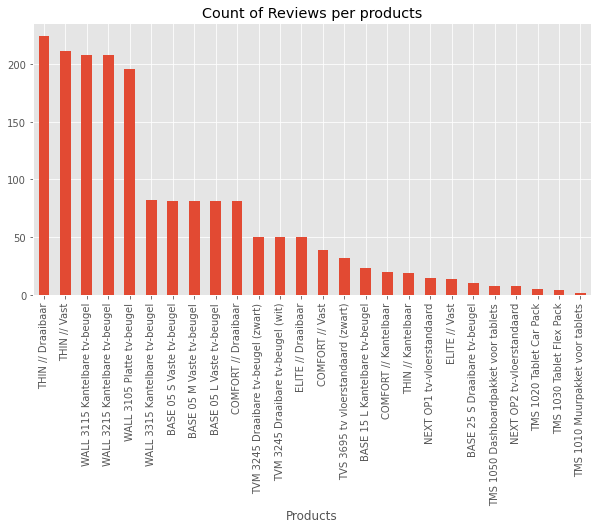

In [21]:
ax = vogels_df['productname'].value_counts().plot(kind='bar', title = 'Count of Reviews per products', figsize=(10,5))
ax.set_xlabel('Products')

In [25]:
vogels_df.duplicated()

0       False
1       False
2       False
3       False
4        True
        ...  
1797    False
1798    False
1799    False
1800    False
1801    False
Length: 1802, dtype: bool

In [27]:
vogels_df.duplicated().sum()

150

In [28]:
vogels_df['review'].duplicated().sum()

664

In [32]:
vogels_df[vogels_df['review'].duplicated()].head(5)

,review,productname
4,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard
5,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard
6,Het ophangsysteem (voor Playstation) is voor 2...,NEXT OP2 tv-vloerstandaard
7,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard
13,"Super , mooi ontwerp en geweldige manier voor ...",NEXT OP1 tv-vloerstandaard


In [35]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [36]:
vogels_df['preprocessed_txt'] = vogels_df.review.apply(preprocess)
vogels_df.head()

,review,productname,preprocessed_txt
0,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...
1,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard,monteren vergen tijd zitten keurig verpakt ont...
2,Het ophangsysteem (voor Playstation) is voor 2...,NEXT OP2 tv-vloerstandaard,ophangsysteem Playstation 2 leren band 2 metal...
3,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard,elkaar zitten zien top
4,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...


In [67]:
vogels_df['Id'] = vogels_df.index +1
vogels_df.head()

,review,productname,preprocessed_txt,Id
0,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,1
1,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard,monteren vergen tijd zitten keurig verpakt ont...,2
2,Het ophangsysteem (voor Playstation) is voor 2...,NEXT OP2 tv-vloerstandaard,ophangsysteem Playstation 2 leren band 2 metal...,3
3,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard,elkaar zitten zien top,4
4,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,5


In [37]:
vogels_df['review'].iloc[30]

"De vogel's TVS 3695 is een echte eyecatcher in je woonkamer!  Wij hebben de tv standaard nu al bijna 2 weken in gebruik. De standaard werd in een goede stevige verpakking thuis bezorgd. Volgens een duidelijke instructie is de standaard makkelijk in elkaar te draaien."

In [38]:
len(vogels_df['review'].iloc[30])

267

In [39]:
vogels_df['preprocessed_txt'].iloc[30]

'vogel TVS 3695 echt eyecatcher woonkamer   tv standaard 2 week gebruik standaard goed stevig verpakking thuis bezorgen duidelijk instructie standaard makkelijk elkaar draaien'

In [40]:
len(vogels_df['preprocessed_txt'].iloc[30])

174

In [43]:
example_review = vogels_df['review'][30]
print(example_review)

De vogel's TVS 3695 is een echte eyecatcher in je woonkamer!  Wij hebben de tv standaard nu al bijna 2 weken in gebruik. De standaard werd in een goede stevige verpakking thuis bezorgd. Volgens een duidelijke instructie is de standaard makkelijk in elkaar te draaien.


In [44]:
example_preprocess = vogels_df['preprocessed_txt'][30]
print(example_preprocess)

vogel TVS 3695 echt eyecatcher woonkamer   tv standaard 2 week gebruik standaard goed stevig verpakking thuis bezorgen duidelijk instructie standaard makkelijk elkaar draaien


In [54]:
example_review_2 = vogels_df['review'][900]
print(example_review_2)

Erg blij met deze tv-beugel, oogt erg netjes en degelijk en erg makkelijk te monteren. Zelfs voor iemand met 2 linkerhanden. Prima aankoop, direct een tweede besteld voor in de keuken!!


In [56]:
example_preprocess_2 = vogels_df['preprocessed_txt'][900]
print(example_preprocess_2)

erg blij tvbeugel ogen erg net degelijk erg makkelijk monteren 2 linkerhanden Prima aankoop direct twee besteld keuken


# TF-IDF


In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
transformed_output = v.fit_transform(vogels_df.preprocessed_txt)
print(v.vocabulary_)

{'twee': 2976, 'week': 3389, 'meubel': 1898, 'bestellen': 470, 'snel': 2671, 'leveren': 1730, 'helaas': 1287, 'blijken': 576, 'één': 3568, 'poot': 2384, 'goed': 1208, 'waardoor': 3352, 'wachten': 3361, 'nieuw': 2055, 'product': 2420, 'uiteindelijk': 3006, 'behoren': 410, 'monteren': 1974, 'vergen': 3150, 'tijd': 2902, 'zitten': 3517, 'keurig': 1578, 'verpakt': 3192, 'ontbreken': 2153, 'niks': 2060, 'handleiding': 1255, 'duidelijk': 903, 'ophangsysteem': 2211, 'playstation': 2366, 'leren': 1719, 'band': 373, 'metalen': 1893, 'buis': 650, 'prijzig': 2410, '99': 130, 'voldoet': 3283, 'gratis': 1221, 'meegelevren': 1865, 'soundbar': 2695, 'nodig': 2067, 'moeite': 1943, 'bluetooth': 584, 'verbinding': 3136, 'pairen': 2293, 'lukken': 1789, 'soms': 2687, 'ontdekken': 2154, 'hem': 1298, 'geluid': 1152, 'draadloos': 871, 'subwoofer': 2805, 'prima': 2411, 'elkaar': 962, 'zien': 3505, 'top': 2932, 'super': 2810, 'mooi': 1976, 'ontwerp': 2172, 'geweldig': 1185, 'manier': 1830, 'opbergen': 2186, 'k

In [108]:
tf = vogels_df['preprocessed_txt'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,snel,119.0
1,leveren,62.0
2,twee,60.0
3,goed,518.0
4,uiteindelijk,33.0


In [109]:
tf.shape

(3934, 2)

In [110]:
tf["words"].nunique()

3934

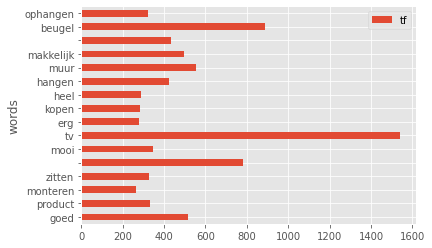

In [195]:
tf[tf["tf"] > 250].plot.barh(x="words", y="tf")
plt.show()

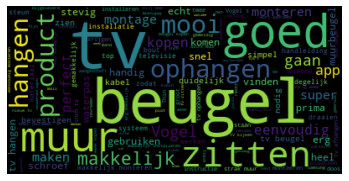

In [198]:
# Wordcloud
from wordcloud import WordCloud
text = " ".join(i for i in vogels_df.preprocessed_txt)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

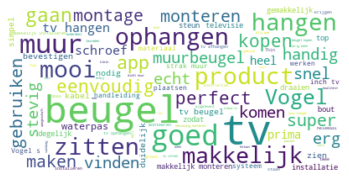

In [199]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")


# **Use of RobBERT**

In [209]:
encoded_text = tokenizer(example_preprocess_2, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_pos' : scores[0],
    'roberta_neg' : scores[1]
}
print(scores_dict)

{'roberta_pos': 0.3852017, 'roberta_neg': 0.61479825}


In [210]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
      'roberta_pos' : scores[0],
      'roberta_neg' : scores[1]
    }
    return scores_dict

In [211]:
res = {}
for i, row in tqdm(vogels_df.iterrows(), total = len(vogels_df)):
  text = row['preprocessed_txt']
  myid = row['Id']
  res[myid] = polarity_scores_roberta(text)

  0%|          | 0/1802 [00:00<?, ?it/s]

In [212]:
res

{1: {'roberta_pos': 0.48051578, 'roberta_neg': 0.5194842},
 2: {'roberta_pos': 0.44475847, 'roberta_neg': 0.5552415},
 3: {'roberta_pos': 0.42380196, 'roberta_neg': 0.5761981},
 4: {'roberta_pos': 0.46893293, 'roberta_neg': 0.531067},
 5: {'roberta_pos': 0.48051578, 'roberta_neg': 0.5194842},
 6: {'roberta_pos': 0.44475847, 'roberta_neg': 0.5552415},
 7: {'roberta_pos': 0.42380196, 'roberta_neg': 0.5761981},
 8: {'roberta_pos': 0.46893293, 'roberta_neg': 0.531067},
 9: {'roberta_pos': 0.45618916, 'roberta_neg': 0.54381084},
 10: {'roberta_pos': 0.4443871, 'roberta_neg': 0.5556129},
 11: {'roberta_pos': 0.43370643, 'roberta_neg': 0.56629354},
 12: {'roberta_pos': 0.39051613, 'roberta_neg': 0.60948384},
 13: {'roberta_pos': 0.4144956, 'roberta_neg': 0.58550453},
 14: {'roberta_pos': 0.45618916, 'roberta_neg': 0.54381084},
 15: {'roberta_pos': 0.4443871, 'roberta_neg': 0.5556129},
 16: {'roberta_pos': 0.43370643, 'roberta_neg': 0.56629354},
 17: {'roberta_pos': 0.39051613, 'roberta_neg': 

vogels_df['productname'].value_counts().plot(kind='bar', title = 'Count of Reviews by products', figsize=(10,5b))

In [88]:
vogels_df['review'].iloc[1800]

'Het design ziet er erg goed uit de kwaliteit is ook heel goed alleen nu nog wat stroef met schuiven (uittrekbare tv beugel) het is heel fijn in gebruik want kan nu lekker in de tuin onder de veranda in alle hoeken tv kijken zowel bij de lounge set als de jacuzzi ik wist dat dit merk vogels goed is omdat we al 1 in de woonkamer hebben alleen dan de versie wat niet uittrekbaar is en deze bevalt ons ook erg goed'

In [213]:
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index':'Id'})
roberta = roberta.merge(vogels_df, how='left')
roberta

,Id,roberta_pos,roberta_neg,review,productname,preprocessed_txt,Rating based on sentiment
0,1,0.480516,0.519484,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,3
1,2,0.444758,0.555242,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard,monteren vergen tijd zitten keurig verpakt ont...,1
2,3,0.423802,0.576198,Het ophangsysteem (voor Playstation) is voor 2...,NEXT OP2 tv-vloerstandaard,ophangsysteem Playstation 2 leren band 2 metal...,3
3,4,0.468933,0.531067,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard,elkaar zitten zien top,5
4,5,0.480516,0.519484,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,3
...,...,...,...,...,...,...,...
1797,1798,0.433461,0.566539,Het kost wat maar de kwaliteit van het product...,ELITE // Draaibaar,kosten kwaliteit product merken meteen qua rob...,5
1798,1799,0.421703,0.578297,Het monteren van de beugel is vrij makkelijk 3...,ELITE // Draaibaar,monteren beugel makkelijk 3 gat boren bijgelev...,4
1799,1800,0.446718,0.553282,Ook zijn er fijne kabel gootjes in verwerkt wa...,ELITE // Draaibaar,fijn kabel goot verwerken waardoor kabel net l...,4
1800,1801,0.374910,0.625090,Het design ziet er erg goed uit de kwaliteit i...,ELITE // Draaibaar,design zien erg goed kwaliteit heel goed stroe...,5


In [222]:
positive_result_df = roberta.loc[roberta['roberta_pos'] > 0.50]
positive_result_df.head(10)

,Id,roberta_pos,roberta_neg,review,productname,preprocessed_txt,Rating based on sentiment
34,35,0.541706,0.458294,"Beste,",TVS 3695 tv vloerstandaard (zwart),Beste,5
50,51,0.541706,0.458294,"Beste,",TVS 3695 tv vloerstandaard (zwart),Beste,5
106,107,0.506787,0.493214,Hoe moeilijk kan het zijn \nDit is echt plug a...,BASE 05 S Vaste tv-beugel,moeilijk \n echt plug and play,3
187,188,0.506787,0.493214,Hoe moeilijk kan het zijn \nDit is echt plug a...,BASE 05 M Vaste tv-beugel,moeilijk \n echt plug and play,3
268,269,0.506787,0.493214,Hoe moeilijk kan het zijn \nDit is echt plug a...,BASE 05 L Vaste tv-beugel,moeilijk \n echt plug and play,3
362,363,0.535196,0.464804,Desondanks wel zeer gemakkelijk te plaatsen.,WALL 3105 Platte tv-beugel,desondanks gemakkelijk plaatsen,3
380,381,0.503311,0.496689,The bracket is great and comes with plenty of ...,WALL 3105 Platte tv-beugel,The bracket Great and comes with plenty fixing...,4
510,511,0.506716,0.493284,Zou u met ons contact kunnen opnemen via consu...,BASE 15 L Kantelbare tv-beugel,contact opnemen via consumercare@vogels.com he...,4
536,537,0.516941,0.483059,I bought this product for my bedroom and it wo...,WALL 3115 Kantelbare tv-beugel,I bought this product for my bedroom and it wo...,5
553,554,0.502862,0.497138,Echt een super product en zeer makkelijk te in...,WALL 3115 Kantelbare tv-beugel,echt super product makkelijk installeren,5


In [224]:
positive_result_df['review'].iloc[34]

'Het openmaken van de doos is al een feest. Het hele proces van installeren is voor je uitgedacht en een leuke puzzeltocht om te doorlopen. Met de Drillright app was het erg makkelijk uit te voeren!'

In [228]:
negative_result_df = roberta.loc[roberta['roberta_pos'] < 0.40]
negative_result_df.head(10)

,Id,roberta_pos,roberta_neg,review,productname,preprocessed_txt,Rating based on sentiment
11,12,0.390516,0.609484,Ik was op zoek naar een manier om mijn tv op t...,NEXT OP1 tv-vloerstandaard,zoek manier tv hangen muur boren komen standaa...,2
16,17,0.390516,0.609484,Ik was op zoek naar een manier om mijn tv op t...,NEXT OP1 tv-vloerstandaard,zoek manier tv hangen muur boren komen standaa...,2
18,19,0.398070,0.601930,Bij aanschaf van de Vogel’s next OP1 waren wij...,NEXT OP1 tv-vloerstandaard,aanschaf Vogel ’s next OP1 uiterst optimistisc...,5
19,20,0.399919,0.600082,Inmiddels hebben wij hem 1 maand in bezit. Onz...,NEXT OP1 tv-vloerstandaard,1 maand bezitten klein woonkamer 20 m2 ogen ru...,1
29,30,0.383297,0.616703,Conclusie \nHet is een erg mooie voet die stev...,TVS 3695 tv vloerstandaard (zwart),conclusie \n erg mooi voet stevig staan kabel ...,5
31,32,0.367682,0.632318,Nu de tv op de standaard is geplaatst oogt dit...,TVS 3695 tv vloerstandaard (zwart),tv standaard plaatsen ogen mooi ruim woonkamer...,3
45,46,0.383297,0.616703,Conclusie \nHet is een erg mooie voet die stev...,TVS 3695 tv vloerstandaard (zwart),conclusie \n erg mooi voet stevig staan kabel ...,5
47,48,0.367682,0.632318,Nu de tv op de standaard is geplaatst oogt dit...,TVS 3695 tv vloerstandaard (zwart),tv standaard plaatsen ogen mooi ruim woonkamer...,3
55,56,0.387120,0.612880,Hoewel ik altijd erg overtuigd ben van de kwal...,BASE 05 S Vaste tv-beugel,erg overtuigen kwaliteit Vogel ’s keer \n beug...,1
61,62,0.397750,0.602250,Prima solide beugel. Plaatsing wijst zichzelf....,BASE 05 S Vaste tv-beugel,Prima solide beugel plaatsing wijzen ingebouwd...,3


In [230]:
negative_result_df['review'].iloc[31]

'Zeer matige vervanging voor de 1205 beugel. Erg dun materiaal. De tv hangt achter een randje van 5 mm.'

# Alternative ranking 


In [120]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [121]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re

In [122]:
tokenizer1 = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model1 = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [124]:
example_preprocess_2 = vogels_df['preprocessed_txt'][900]
print(example_preprocess_2)

erg blij tvbeugel ogen erg net degelijk erg makkelijk monteren 2 linkerhanden Prima aankoop direct twee besteld keuken


In [126]:
tokens = tokenizer1.encode(example_preprocess_2, return_tensors='pt')
result = model1(tokens)
result

SequenceClassifierOutput(loss=None, logits=tensor([[-2.0328, -2.0365, -0.0258,  1.5605,  1.9076]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [127]:
example_review_2 = vogels_df['review'][900]
print(example_review_2)

Erg blij met deze tv-beugel, oogt erg netjes en degelijk en erg makkelijk te monteren. Zelfs voor iemand met 2 linkerhanden. Prima aankoop, direct een tweede besteld voor in de keuken!!


In [128]:
tokens = tokenizer1.encode(example_review_2, return_tensors='pt')
result = model1(tokens)
result

SequenceClassifierOutput(loss=None, logits=tensor([[-2.7426, -2.8300, -0.1796,  2.0887,  2.8377]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The position with the highest score represents the sentiment rating e.g. [9, 2,1,-2,-5] is a rating of 1 (the ratings starts from 1 to 5 from left to right)


In [129]:
result.logits

tensor([[-2.7426, -2.8300, -0.1796,  2.0887,  2.8377]],
       grad_fn=<AddmmBackward0>)

In [130]:
int(torch.argmax(result.logits))+1

5

In [131]:
def sentiment_score(preprocessed_txt):
  tokens = tokenizer1.encode(preprocessed_txt, return_tensors='pt')
  result = model1(tokens)
  return int(torch.argmax(result.logits))+1

In [132]:
res1 = {}
for i, row in tqdm(vogels_df.iterrows(), total = len(vogels_df)):
  text = row['preprocessed_txt']
  myid = row['Id']
  res1[myid] = sentiment_score(text)

  0%|          | 0/1802 [00:00<?, ?it/s]

In [137]:
res1

{1: 3,
 2: 1,
 3: 3,
 4: 5,
 5: 3,
 6: 1,
 7: 3,
 8: 5,
 9: 5,
 10: 1,
 11: 5,
 12: 2,
 13: 4,
 14: 5,
 15: 1,
 16: 5,
 17: 2,
 18: 4,
 19: 5,
 20: 1,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 26: 5,
 27: 3,
 28: 3,
 29: 3,
 30: 5,
 31: 5,
 32: 3,
 33: 1,
 34: 5,
 35: 5,
 36: 5,
 37: 1,
 38: 4,
 39: 5,
 40: 5,
 41: 5,
 42: 5,
 43: 3,
 44: 3,
 45: 3,
 46: 5,
 47: 5,
 48: 3,
 49: 1,
 50: 5,
 51: 5,
 52: 5,
 53: 1,
 54: 4,
 55: 5,
 56: 1,
 57: 1,
 58: 4,
 59: 4,
 60: 5,
 61: 5,
 62: 3,
 63: 5,
 64: 5,
 65: 1,
 66: 1,
 67: 4,
 68: 4,
 69: 5,
 70: 5,
 71: 3,
 72: 5,
 73: 5,
 74: 3,
 75: 1,
 76: 5,
 77: 1,
 78: 1,
 79: 3,
 80: 1,
 81: 1,
 82: 4,
 83: 2,
 84: 1,
 85: 5,
 86: 5,
 87: 1,
 88: 1,
 89: 2,
 90: 1,
 91: 4,
 92: 3,
 93: 3,
 94: 5,
 95: 1,
 96: 5,
 97: 5,
 98: 1,
 99: 1,
 100: 4,
 101: 5,
 102: 5,
 103: 4,
 104: 3,
 105: 1,
 106: 3,
 107: 3,
 108: 5,
 109: 4,
 110: 1,
 111: 5,
 112: 5,
 113: 4,
 114: 3,
 115: 5,
 116: 3,
 117: 1,
 118: 1,
 119: 3,
 120: 5,
 121: 4,
 122: 5,
 123: 4,
 

In [140]:
multilingual_sent = pd.DataFrame(res1)

ValueError: ignored

In [ ]:
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index':'Id'})
roberta = roberta.merge(vogels_df, how='left')
roberta

In [142]:
vogels_df['Rating based on sentiment'] = vogels_df['preprocessed_txt'].apply(lambda x: sentiment_score(x))

In [143]:
vogels_df.head()

,review,productname,preprocessed_txt,Id,Rating based on sentiment
0,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,1,3
1,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard,monteren vergen tijd zitten keurig verpakt ont...,2,1
2,Het ophangsysteem (voor Playstation) is voor 2...,NEXT OP2 tv-vloerstandaard,ophangsysteem Playstation 2 leren band 2 metal...,3,3
3,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard,elkaar zitten zien top,4,5
4,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,5,3


In [144]:
vogels_df['Rating based on sentiment'].value_counts()

5    928
4    420
1    250
3    165
2     39
Name: Rating based on sentiment, dtype: int64

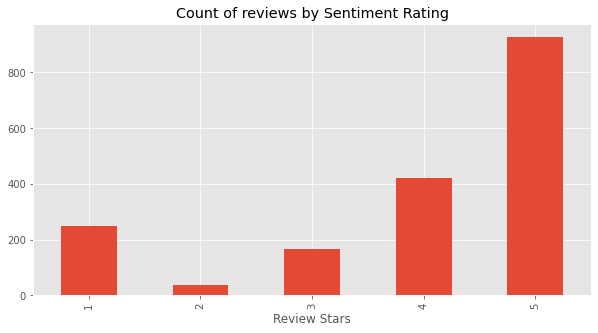

In [148]:
bx = vogels_df['Rating based on sentiment'].value_counts().sort_index().plot(kind='bar', title='Count of reviews by Sentiment Rating', figsize=(10,5))
bx.set_xlabel('Review Stars')
plt.show()

In [165]:
positive_vogels = vogels_df.loc[vogels_df['Rating based on sentiment'] >= 4]
positive_vogels.head(20)

,review,productname,preprocessed_txt,Id,Rating based on sentiment
3,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard,elkaar zitten zien top,4,5
7,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard,elkaar zitten zien top,8,5
8,"Super , mooi ontwerp en geweldige manier voor ...",NEXT OP1 tv-vloerstandaard,super mooi ontwerp geweldig manier opbergen kabel,9,5
10,Al jaren hadden we een lelijke standaard. Gewo...,NEXT OP1 tv-vloerstandaard,jaar lelijk standaard mooi bestaan nergens moo...,11,5
12,Wat opvalt is het design en de gebruikte mater...,NEXT OP1 tv-vloerstandaard,opvallen design gebruiken materiaal echt hout ...,13,4
13,"Super , mooi ontwerp en geweldige manier voor ...",NEXT OP1 tv-vloerstandaard,super mooi ontwerp geweldig manier opbergen kabel,14,5
15,Al jaren hadden we een lelijke standaard. Gewo...,NEXT OP1 tv-vloerstandaard,jaar lelijk standaard mooi bestaan nergens moo...,16,5
17,Wat opvalt is het design en de gebruikte mater...,NEXT OP1 tv-vloerstandaard,opvallen design gebruiken materiaal echt hout ...,18,4
18,Bij aanschaf van de Vogel’s next OP1 waren wij...,NEXT OP1 tv-vloerstandaard,aanschaf Vogel ’s next OP1 uiterst optimistisc...,19,5
20,Daarnaast waren wij bang dat onze huiskat hem ...,NEXT OP1 tv-vloerstandaard,daarnaast bang huiskat vernielen gelukkig aang...,21,5


In [170]:
positive_vogels.shape

(1348, 5)

In [162]:
positive_vogels['review'].iloc[93]

'Vorige week besteld, was zo gemonteerd.\nIdeaal om nu tv te kijken.'

In [173]:
transformed_output_pos = v.fit_transform(positive_vogels.preprocessed_txt)
print(v.vocabulary_)

{'elkaar': 735, 'zitten': 2644, 'zien': 2635, 'top': 2217, 'super': 2124, 'mooi': 1509, 'ontwerp': 1647, 'geweldig': 910, 'manier': 1401, 'opbergen': 1659, 'kabel': 1177, 'jaar': 1165, 'lelijk': 1315, 'standaard': 2073, 'bestaan': 363, 'nergens': 1563, 'vinden': 2439, 'enigszins': 742, 'betaalbaar': 369, 'product': 1836, 'bijzonder': 435, 'aantrekkelijk': 150, 'geprijsd': 899, 'verpakking': 2394, 'open': 1661, 'maken': 1389, 'begrijpen': 316, 'ineens': 1096, 'echt': 706, 'stevig': 2092, 'hout': 1054, 'glad': 925, 'afwerken': 218, 'past': 1754, 'perfect': 1762, 'uitzoeken': 2308, 'soundbar': 2043, 'bevestigen': 383, 'plaat': 1777, 'compleet': 554, 'staan': 2065, 'prachtig': 1815, 'interieur': 1147, 'vrouw': 2512, 'erg': 750, 'blij': 439, 'aanrader': 139, 'opvallen': 1698, 'design': 611, 'gebruiken': 858, 'materiaal': 1410, 'massief': 1405, 'rvs': 1934, 'steun': 2088, 'leveren': 1326, 'kartonnen': 1198, 'doos': 668, 'beetje': 309, 'simpel': 1994, 'uiteindelijk': 2261, 'draaien': 673, 'vo

In [174]:
tf_pos = positive_vogels['preprocessed_txt'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf_pos.columns = ["words", "tf"]
tf_pos.head()

,words,tf
0,elkaar,26.0
1,zitten,178.0
2,zien,77.0
3,top,46.0
4,super,183.0


In [175]:
tf_pos.shape

(2971, 2)

In [177]:
tf_pos["words"].nunique()

2971

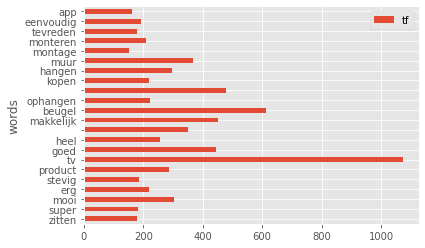

In [192]:
tf_pos[tf_pos["tf"] > 150].plot.barh(x="words", y="tf")
plt.show()

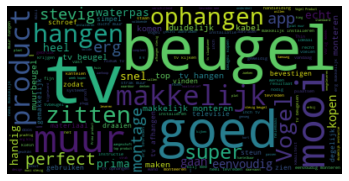

In [203]:
text_pos = " ".join(i for i in positive_vogels.preprocessed_txt)
wordcloud = WordCloud().generate(text_pos)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

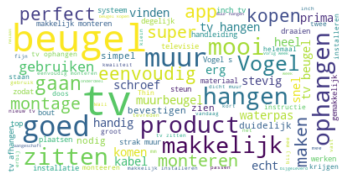

In [204]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 0, 'Products')

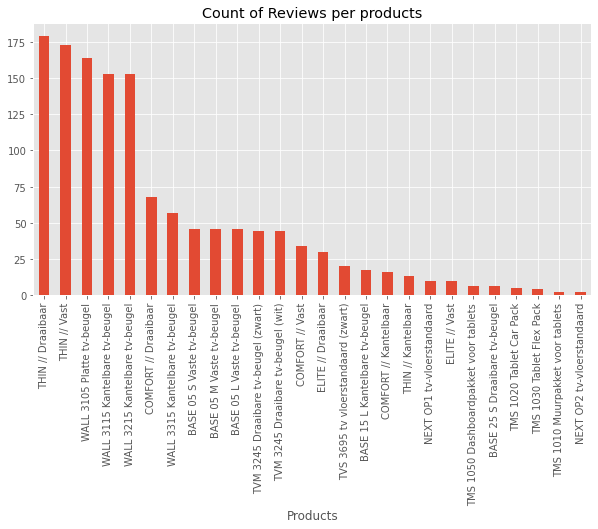

In [208]:
ax = positive_vogels['productname'].value_counts().plot(kind='bar', title = 'Count of Reviews per products', figsize=(10,5))
ax.set_xlabel('Products')

In [164]:
negative_vogels = vogels_df.loc[vogels_df['Rating based on sentiment'] <= 2]
negative_vogels.head(20)

,review,productname,preprocessed_txt,Id,Rating based on sentiment
1,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard,monteren vergen tijd zitten keurig verpakt ont...,2,1
5,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard,monteren vergen tijd zitten keurig verpakt ont...,6,1
9,Dit is simpelweg het mooiste tv-standaard wat ...,NEXT OP1 tv-vloerstandaard,simpelweg mooi tv-standaard koop graag goedkoo...,10,1
11,Ik was op zoek naar een manier om mijn tv op t...,NEXT OP1 tv-vloerstandaard,zoek manier tv hangen muur boren komen standaa...,12,2
14,Dit is simpelweg het mooiste tv-standaard wat ...,NEXT OP1 tv-vloerstandaard,simpelweg mooi tv-standaard koop graag goedkoo...,15,1
16,Ik was op zoek naar een manier om mijn tv op t...,NEXT OP1 tv-vloerstandaard,zoek manier tv hangen muur boren komen standaa...,17,2
19,Inmiddels hebben wij hem 1 maand in bezit. Onz...,NEXT OP1 tv-vloerstandaard,1 maand bezitten klein woonkamer 20 m2 ogen ru...,20,1
32,Het enige wat ontbreekt is de montage van de s...,TVS 3695 tv vloerstandaard (zwart),ontbreken montage soundbar willen graag soundb...,33,1
36,We zagen ook de opmerking over de soundbar ins...,TVS 3695 tv vloerstandaard (zwart),zien opmerking soundbar installatie mail sture...,37,1
48,Het enige wat ontbreekt is de montage van de s...,TVS 3695 tv vloerstandaard (zwart),ontbreken montage soundbar willen graag soundb...,49,1


In [172]:
negative_vogels.shape

(289, 5)

In [158]:
negative_vogels['review'].iloc[9]

'Het enige wat ontbreekt is de montage van de soundbar. We willen graag de soundbar onder de tv hangen maar dit krijgen wij niet voor elkaar.'

In [182]:
transformed_output = v.fit_transform(negative_vogels.preprocessed_txt)
print(v.vocabulary_)

{'monteren': 851, 'vergen': 1352, 'tijd': 1249, 'zitten': 1516, 'keurig': 651, 'verpakt': 1373, 'ontbreken': 925, 'niks': 886, 'handleiding': 514, 'duidelijk': 368, 'simpelweg': 1127, 'mooi': 853, 'tv': 1275, 'standaard': 1177, 'koop': 676, 'graag': 500, 'goedkoop': 494, 'variant': 1327, 'kopen': 679, 'krijgen': 688, 'simpel': 1126, 'zwart': 1538, 'daarvoor': 309, 'betaalen': 196, 'geld': 464, 'jaar': 623, 'besluiten': 190, 'designstuk': 325, 'gaan': 445, 'duurs': 375, 'verwachten': 1389, 'kwaliteit': 695, 'twijfel': 1282, 'geolied': 475, 'hout': 560, 'zwaar': 1534, 'rvs': 1090, 'pinnen': 998, 'nadachten': 864, 'snoear': 1146, 'lopen': 741, 'perfect': 990, 'achterste': 93, 'poot': 1021, 'verdwijnen': 1350, 'direct': 334, 'gordijn': 498, 'lijken': 730, 'alsof': 131, 'batterijen': 154, 'snoer': 1147, 'zien': 1508, 'erg': 403, 'blij': 235, 'aankoop': 70, 'zoek': 1520, 'manier': 769, 'hangen': 516, 'muur': 856, 'boren': 246, 'komen': 674, 'woonkamer': 1496, 'groot': 503, '23m2': 16, 'doord

In [183]:
tf_neg = negative_vogels['preprocessed_txt'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf_neg.columns = ["words", "tf"]
tf_neg.head()

,words,tf
0,monteren,33.0
1,vergen,2.0
2,tijd,7.0
3,zitten,93.0
4,keurig,4.0


In [185]:
tf_neg.shape

(1629, 2)

In [186]:
tf_neg["words"].nunique()

1629

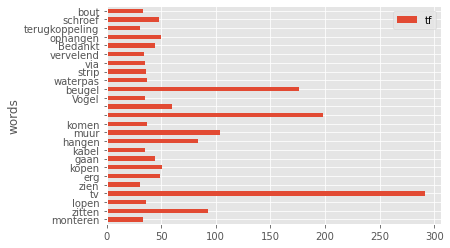

In [189]:
tf_neg[tf_neg["tf"] > 30].plot.barh(x="words", y="tf")
plt.show()

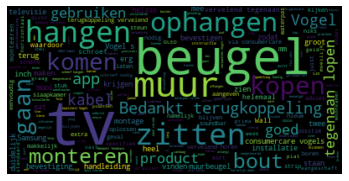

In [205]:
text_neg = " ".join(i for i in negative_vogels.preprocessed_txt)
wordcloud = WordCloud().generate(text_neg)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

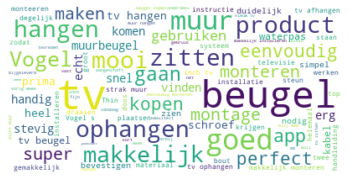

In [206]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 0, 'Products')

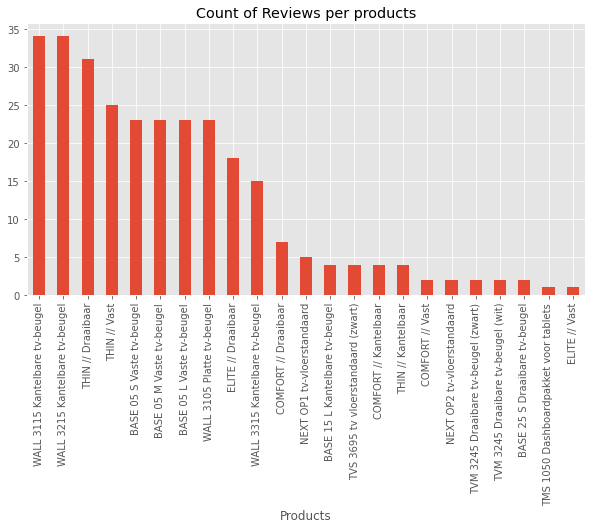

In [207]:
ax = negative_vogels['productname'].value_counts().plot(kind='bar', title = 'Count of Reviews per products', figsize=(10,5))
ax.set_xlabel('Products')

In [231]:
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index':'Id'})
roberta = roberta.merge(vogels_df, how='left')
roberta

,Id,roberta_pos,roberta_neg,review,productname,preprocessed_txt,Rating based on sentiment
0,1,0.480516,0.519484,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,3
1,2,0.444758,0.555242,"Het monteren vergt wat tijd, maar alles zit ke...",NEXT OP2 tv-vloerstandaard,monteren vergen tijd zitten keurig verpakt ont...,1
2,3,0.423802,0.576198,Het ophangsysteem (voor Playstation) is voor 2...,NEXT OP2 tv-vloerstandaard,ophangsysteem Playstation 2 leren band 2 metal...,3
3,4,0.468933,0.531067,Wanneer alles in elkaar zit ziet het er top uit.,NEXT OP2 tv-vloerstandaard,elkaar zitten zien top,5
4,5,0.480516,0.519484,Twee weken geleden dit meubel door mij besteld...,NEXT OP2 tv-vloerstandaard,twee week meubel bestellen snel leveren helaas...,3
...,...,...,...,...,...,...,...
1797,1798,0.433461,0.566539,Het kost wat maar de kwaliteit van het product...,ELITE // Draaibaar,kosten kwaliteit product merken meteen qua rob...,5
1798,1799,0.421703,0.578297,Het monteren van de beugel is vrij makkelijk 3...,ELITE // Draaibaar,monteren beugel makkelijk 3 gat boren bijgelev...,4
1799,1800,0.446718,0.553282,Ook zijn er fijne kabel gootjes in verwerkt wa...,ELITE // Draaibaar,fijn kabel goot verwerken waardoor kabel net l...,4
1800,1801,0.374910,0.625090,Het design ziet er erg goed uit de kwaliteit i...,ELITE // Draaibaar,design zien erg goed kwaliteit heel goed stroe...,5


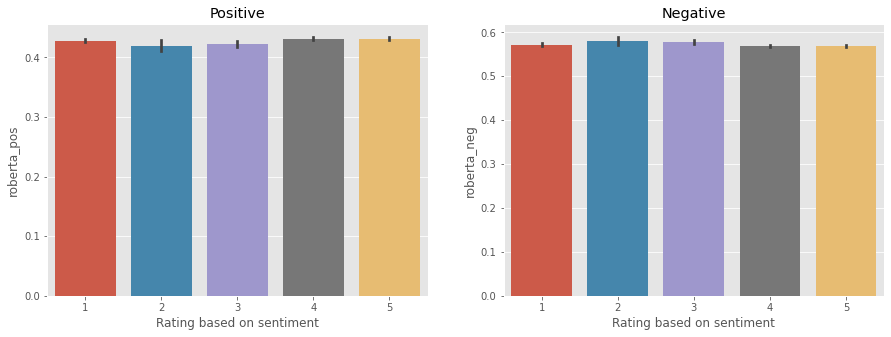

In [232]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.barplot(data=roberta,x='Rating based on sentiment', y='roberta_pos', ax = axs[0])
sns.barplot(data=roberta,x='Rating based on sentiment', y='roberta_neg', ax = axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.show()